In [32]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_csv('sessions_day_output.csv')
# 2. Convert boolean columns to 0/1 (in case they come as 'True'/'False' or bool)
df['is_scan_like'] = df['is_scan_like'].astype(int)
df['is_unusual_protocol'] = df['is_unusual_protocol'].astype(int)

# 3. Convert 'session_direction' to 0 ('inbound') and 1 ('outbound')
df['session_direction'] = df['session_direction'].map({'inbound': 0, 'outbound': 1})
df['session_role'] = df['session_role'].map({'client': 0, 'server': 1})

# 4. One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=['protocol_type'], drop_first=True)
df.drop(columns=['hour_of_day'], inplace=True)

## dropping destination and source ports

# 6. Filter by relevant columns for the model
features = [
    'duration_sec',
    'packet_count', 'total_bytes', 'bandwidth_bps','session_role',
    'src_ip_session_count', 'unique_dst_ports_contacted',
    'is_scan_like', 'is_unusual_protocol',
    'session_direction', 'hour_sin', 'hour_cos','frequency','dst_ip_session_count'

] + [col for col in df.columns if col.startswith('protocol_type_')]

# session_role is not included yet because it's commented out

df_model = df[features]
# print(df_model.head())
# df.head()

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Explicitly define the columns you DO want to scale
scale_columns = ['duration_sec', 'packet_count', 'total_bytes', 'bandwidth_bps',
                'src_ip_session_count', 'unique_dst_ports_contacted', 'frequency','dst_ip_session_count']

# Make sure these columns exist
scale_columns = [col for col in scale_columns if col in df.columns]

# Use only the columns from your features list
X = df[features].copy()

# Scale only the selected columns
scaler = StandardScaler()
X_scaled_part = scaler.fit_transform(X[scale_columns])
X_scaled_df = pd.DataFrame(X_scaled_part, columns=scale_columns, index=X.index)

# Replace only those columns in the original DataFrame
X_final = X.copy()
X_final[scale_columns] = X_scaled_df
X_final = X_final.astype({col: int for col in X_final.select_dtypes(include=['bool']).columns})
X_final.head()


C:\Users\Guillermo\AppData\Local\Temp\ipykernel_30548\2839760961.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sessions_day_output.csv')


,duration_sec,packet_count,total_bytes,bandwidth_bps,session_role,src_ip_session_count,unique_dst_ports_contacted,is_scan_like,is_unusual_protocol,session_direction,...,protocol_type_465.0,protocol_type_53.0,protocol_type_67.0,protocol_type_68.0,protocol_type_80.0,protocol_type_8080.0,protocol_type_8080.0,protocol_type_88.0,protocol_type_993.0,protocol_type_unknown
0,9.147193,8.976689,0.704413,-0.026325,1,-0.819113,-0.510216,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-0.114532,-0.114576,-0.004438,-0.026817,1,-0.819113,-0.510216,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.114532,-0.114576,-0.004435,-0.026614,1,-0.819113,-0.510216,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.114532,-0.114576,-0.004415,-0.025287,1,-0.818181,-0.510216,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.114532,-0.114576,-0.004427,-0.026085,1,-0.818181,-0.510216,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
X_final.columns

Index(['duration_sec', 'packet_count', 'total_bytes', 'bandwidth_bps',
       'session_role', 'src_ip_session_count', 'unique_dst_ports_contacted',
       'is_scan_like', 'is_unusual_protocol', 'session_direction', 'hour_sin',
       'hour_cos', 'frequency', 'dst_ip_session_count', 'protocol_type_1352.0',
       'protocol_type_1352.0', 'protocol_type_1433.0', 'protocol_type_1433.0',
       'protocol_type_1536.0', 'protocol_type_1536.0', 'protocol_type_3306.0',
       'protocol_type_3306.0', 'protocol_type_8080.0', 'protocol_type_8080.0',
       'protocol_type_110.0', 'protocol_type_123.0', 'protocol_type_1352.0',
       'protocol_type_1352.0', 'protocol_type_143.0', 'protocol_type_1433.0',
       'protocol_type_1433.0', 'protocol_type_1536.0', 'protocol_type_1536.0',
       'protocol_type_20.0', 'protocol_type_21.0', 'protocol_type_22.0',
       'protocol_type_23.0', 'protocol_type_25.0', 'protocol_type_3306.0',
       'protocol_type_3306.0', 'protocol_type_3389.0', 'protocol_type_389.

## Create Dataset and Data Loader

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader

class SessionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = SessionDataset(X_final)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)


## Define autoencoder how it will work

In [36]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_final.shape[1]
model = Autoencoder(input_dim).to("cuda" if torch.cuda.is_available() else "cpu")


## Training Auto Encoder

In [ ]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training
for epoch in range(200):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader):.4f}")


cuda
Epoch 1 - Loss: 0.0334
Epoch 2 - Loss: 0.0293
Epoch 3 - Loss: 0.0252
Epoch 4 - Loss: 0.0143
Epoch 5 - Loss: 0.0155
Epoch 6 - Loss: 0.0120
Epoch 7 - Loss: 0.0162
Epoch 8 - Loss: 0.0118
Epoch 9 - Loss: 0.0143
Epoch 10 - Loss: 0.0155
Epoch 11 - Loss: 0.0201
Epoch 12 - Loss: 0.0110
Epoch 13 - Loss: 0.0149
Epoch 14 - Loss: 0.0086
Epoch 15 - Loss: 0.0121
Epoch 16 - Loss: 0.0089
Epoch 17 - Loss: 0.0214
Epoch 18 - Loss: 0.0120
Epoch 19 - Loss: 0.0214
Epoch 20 - Loss: 0.0111
Epoch 21 - Loss: 0.0294
Epoch 22 - Loss: 0.0184
Epoch 23 - Loss: 0.0117
Epoch 24 - Loss: 0.0107
Epoch 25 - Loss: 0.0141
Epoch 26 - Loss: 0.0116
Epoch 27 - Loss: 0.0149
Epoch 28 - Loss: 0.0061
Epoch 29 - Loss: 0.0081
Epoch 30 - Loss: 0.0144
Epoch 31 - Loss: 0.0162
Epoch 32 - Loss: 0.0098
Epoch 33 - Loss: 0.0182
Epoch 34 - Loss: 0.0100
Epoch 35 - Loss: 0.0094
Epoch 36 - Loss: 0.0217
Epoch 37 - Loss: 0.0096
Epoch 38 - Loss: 0.0210
Epoch 39 - Loss: 0.0268
Epoch 40 - Loss: 0.0146
Epoch 41 - Loss: 0.0127
Epoch 42 - Loss: 0.0

## Get the data

In [ ]:
model.eval()
with torch.no_grad():
    all_data = torch.tensor(X_final.values, dtype=torch.float32).to(device)
    encoded_data = model.encoder(all_data).cpu().numpy()
    reconstructed = model(all_data).cpu().numpy()

# Calculate the reconstruction error
import numpy as np
reconstruction_error = np.mean((X_final.values - reconstructed) ** 2, axis=1)


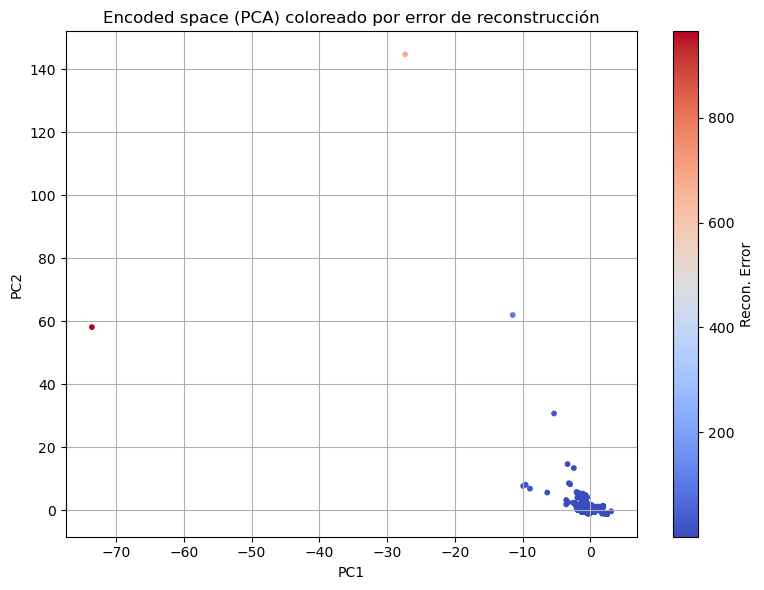

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
encoded_2d = pca.fit_transform(encoded_data)

plt.figure(figsize=(8, 6))
plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=reconstruction_error, cmap='coolwarm', s=10)
plt.colorbar(label='Recon. Error')
plt.title("Encoded space (PCA) coloreado por error de reconstrucción")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Isolation Forest Mix

In [ ]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iforest.fit(encoded_data)

# Predictions
iforest_labels = iforest.predict(encoded_data)  # -1 = anomalía, 1 = normal
iforest_scores = iforest.decision_function(encoded_data)


In [42]:
results_df = X_final.copy()
results_df['reconstruction_error'] = reconstruction_error
results_df['iforest_score'] = iforest_scores
results_df['iforest_label'] = iforest_labels  # -1 = anomalía


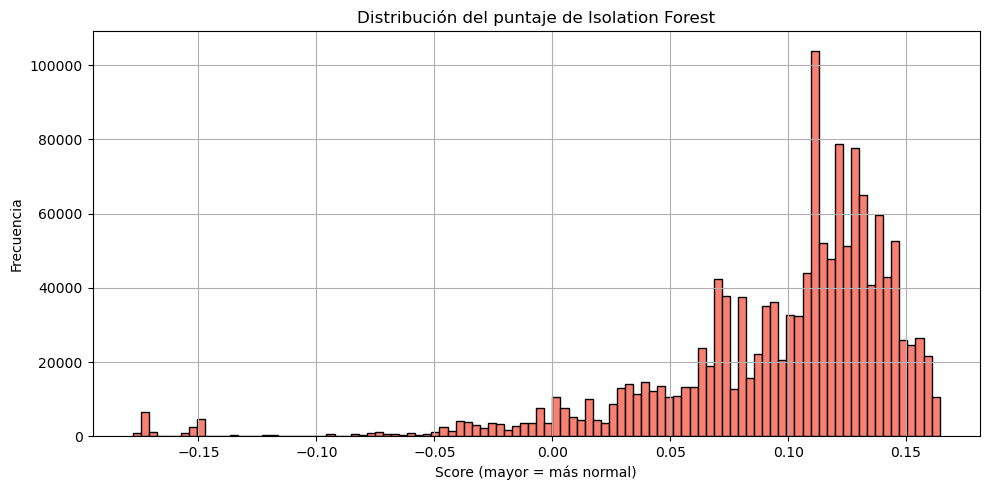

In [43]:
plt.figure(figsize=(10, 5))
plt.hist(iforest_scores, bins=100, color='salmon', edgecolor='black')
plt.title("Distribución del puntaje de Isolation Forest")
plt.xlabel("Score (mayor = más normal)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Load the original DataFrame (make sure to use the same file and order)
df_original = pd.read_csv('sessions_day_output.csv')

# Ensure that session_id is present
assert 'session_id' in df_original.columns, "session_id not found in the original CSV"

# Step 1: Define reconstruction threshold
threshold = np.percentile(reconstruction_error, 95)

# Step 2: Create results DataFrame (features + metrics)
results_df = X_final.copy()
results_df['reconstruction_error'] = reconstruction_error
results_df['iforest_score'] = iforest_scores
results_df['iforest_label'] = iforest_labels
results_df['anomaly_autoencoder'] = (results_df['reconstruction_error'] > threshold).astype(int)
results_df['anomaly_iforest'] = (results_df['iforest_label'] == -1).astype(int)

# Step 3: Add original session_id
results_df['session_id'] = df_original['session_id']

# Step 4: Filter anomalies detected by at least one method
anomalies = results_df[
    (results_df['anomaly_autoencoder'] == 1) | 
    (results_df['anomaly_iforest'] == 1)
]

# Step 5: Save to CSV
anomalies.to_csv("autoencoders_anomalous_sessions.csv", index=False)

print(f"Exported {len(anomalies)} anomalous sessions to 'autoencoders_anomalous_sessions.csv'")


C:\Users\Guillermo\AppData\Local\Temp\ipykernel_30548\3997639746.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv('sessions_day_output.csv')


Exportadas 130482 sesiones anómalas a 'autoencoders_anomalous_sessions.csv'
